<a href="https://colab.research.google.com/github/andrewlys/ECMA-31330/blob/main/Project/Code/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now we perform a baseline training. Our model will be an Temporal Fusion Transformer (TFT). We use the implementation provided by PyTorch Forecast. Our training set will be from January 1970 to December 2009. Our test set will be from January 2010 to December 2024.

There are multiple methods to estimate if a stock is a value trap. The most principled is to perform an ordinal regression on the TTM Price Change. This is also the most difficult. The TFT model outputs quantiles, and so we leverage these quantiles to estimate the ordinal positions of the stocks. We outline the method as follows:
* Select quantiles $q_1, \ldots, q_n$.
* For each company $i$, receive predictions $\hat{y_i} = (\hat{y_i}(q_1), \ldots, \hat{y_i}(q_n))$.
* Choose an ordering of $[n]$.
* Order $\hat{y_i}$ lexicographically.

The quantiles selected and the ordering of $[n]$ are chosen via cross-validation. For simplicity, we will only use two quantiles, however in practice, cross validation for both of these is strongly reccommended, but computationally expensive.



We provide descriptions for each of the features included in our dataset. If there is a q at the end of a feature name, this indicates this data is reported quarterly. If there is a y at the end of a feature name, this indicates, the data is reported yearly.

* time: An integer that represents the current quarter. 0 for the first quarter in the dataset. Increments by 1 for each quarter.
* gvkey: Unique company id
* datadate: Year and month
* fqtr: Financial Quarter
* indfmt: Style of financial reports. All will be industrial              
* consol: Level of consolidation. All will be consolidation           
* popsrc: Population Source. All will be domestic/US
* datafmt: Data Format.
* curcdq: Currency. All will be USD
* actq: Current Assets Total
* apq: Accounts Payable
* atq: Assets total
* cheq: Cash and short term investments
* cogsq: Cost of Goods Sold
* cshoq: Common Shares Outstanding
* dlcq: Debt in Current Liabilities
* dlttq: Long Term Debt - Total
* intanq: Intangible Assets
* lctq: Current Liabilities - Total
* ltq: Liabilities - Total
* mibq: Noncontrolling Interest
* niq: Net Income (Loss)
* oiadpq: Operating Income After Depreciation
* ppentq: Property, Plant, and Equipment - Total
* pstkq: Preferred/Preference Stock - Total
* rectq: Receivables Total
* saleq: Sales/Turnover (Net)
* seqq: Shareholders' Equity.
* capxy: Capital Expenditures
* cdvcy: Cash Dividends on Common Stock
* exchg: Exchange on Which Stock is Traded On. Either NYSE, NASDAQ, or AMEX
* costat: Postal Code Character
* prccq: Price Close
* prclq: Price Low
* loc: Location of Company Headquarters. Country. Will always be USA
* ipodate: Date of IPO. Is NaN if no IPO or date is missing for other reason.
* ret_3m: Percent Price Change over last 3 months
* ret_9m: Percent Price Change over last 9 months
* ret_12m: Percent Price Change over last 12 months
* ret_18m: Percent Price Change Over Last 18 Months
* bkmktq: Book to Market.
$$\text{Book to Market } = \frac{\text{Shareholder Equity}}{\text{Closing Price } \cdot \text{ Common Shares Outstanding}} $$
* rel:bkmktq: Percentile by Book to Market
* evq: Enterprise Value
\begin{align*}
\text{Enterprise Value} &= \text{Closing Price } \cdot \text{ Common Shares Outstanding}\\
 &+ \text{ Long Term Debt } + \text{ Debt in Current Liabilities}\\
 &- \text{ Cash and Short Term Investments}
\end{align*}
* eyq: Earnings Yield:
$$
\text{Earnings Yield} = \frac{\text{Operating Income After Depreciation}}{\text{Enterprise Value}}
$$
* rel:eyq: Percentile by Earnings Yield

The next set of variables are just indicators for if a given entry is missing. Refer to the NaN policy to see how missing values are treated.

The next set of variables are the seasonalized variables. Seasonalization is only applied to the variables that are continuous. We list them here for posterity. Refer to the Seasonalizaiton section to see how this is implemented.
* szn:actq            
* szn:apq             
* szn:atq             
* szn:cheq            
* szn:cogsq           
* szn:cshoq           
* szn:dlcq            
* szn:dlttq           
* szn:intanq          
* szn:lctq            
* szn:ltq             
* szn:mibq            
* szn:niq             
* szn:oiadpq          
* szn:ppentq          
* szn:pstkq           
* szn:rectq           
* szn:saleq           
* szn:seqq            
* szn:capxy           
* szn:cdvcy           
* szn:prccq           
* szn:prclq           
* szn:ret_3m          
* szn:rel:ret_3m      
* szn:ret_9m          
* szn:rel:ret_9m      
* szn:ret_12m         
* szn:rel:ret_12m     
* szn:ret_18m         
* szn:rel:ret_18m     
* szn:bkmktq          
* szn:rel:bkmktq      
* szn:evq             
* szn:eyq             
* szn:rel:eyq         

---

We can divide this features into five categories:
* Static Categoricals: Features like gvkey
* Time Varying Known Categoricals: Features like the financial quarter.
* Time Varying Known Reals: IPODate is the only one.
* Time Varying Unknown Categoricals: NaN features
* Time Varying Unknown Reals: All of the rest of the features.

In [ ]:
%pip install -q pytorch-forecasting
%pip uninstall tensorflow
%pip install -U -q tensorboard
%pip install -q pytorch_optimizer

import os
import typing

import numpy as np
import pandas as pd
import torch
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import (
    BaseModel, TemporalFusionTransformer
)
from pytorch_forecasting.metrics import (
    QuantileLoss, CrossEntropy
)

import lightning.pytorch as pl
from lightning.pytorch.callbacks import (
    EarlyStopping, LearningRateMonitor
)
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

import pytorch_optimizer
torch.set_float32_matmul_precision('medium')

In [ ]:
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    data_pwd = '/content/drive/My Drive/Colab Notebooks/ECMA 31330 Project/'
else:
    data_pwd = './'

Mounted at /content/drive


In our model we feed in 20 quarters of time series data for a company. We output 20 quarters of results. These results are the probability that in that quarter, the stock is a value trap.

The following is a list of all the hyperparameters we need for our TFT model. We note hyperparameters that are chosen with cross validation with an asterisk.

```python
* hidden_size # Number of nodes in a layer
lstm_layers = 2
* dropout_rate
output_size = 2 # necessary for CrossEntropy metric
loss = CrossEntropy()
attention_head_size = 4 # Number of Attention Heads
* hidden_continous_sizes # <= hidden_size. Num nodes set aside for cts features
* learning_rate
* reduce_on_plateau_patience
* gradient_clip_val
```



In [ ]:
# hyper-parameters
num_layers = 2
hidden_size = 16
attention_head_size = 4
hidden_continuous_size = 8
droput = 0.1
output_size = 2
loss = CrossEntropy()
learning_rate = 0.001
epochs = 10
num_workers = 8
batch_size = 128

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
log_dir = data_pwd + 'logging_dir'  # Create a directory if it doesn't exist
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)  # logging results to a tensorboard

In [ ]:
# dataloaders
train = torch.load(data_pwd + 'train.pt', weights_only = False)
test = torch.load(data_pwd + 'test.pt', weights_only = False)
val = torch.load(data_pwd + 'val.pt', weights_only = False)
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = val.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=num_workers)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=num_workers)

In [ ]:
# configure model
tft = TemporalFusionTransformer.from_dataset(
  train,
  hidden_size = hidden_size,
  lstm_layers=num_layers,
  dropout=droput,
  output_size=output_size,
  loss=loss,
  attention_head_size=attention_head_size,
  hidden_continuous_size=hidden_continuous_size,
  learning_rate=learning_rate,
  optimizer = 'ranger',
  log_interval=0
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# configure trainer
tft_trainer = pl.Trainer(
    accelerator='auto',
    devices='auto',
    check_val_every_n_epoch=2,
    # fast_dev_run=True,
    max_epochs=epochs,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    enable_model_summary=True,
    enable_checkpointing=True,
    gradient_clip_val=0.1
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
# tune hyper parameters
%pip install -q optuna statsmodels
%pip install -q optuna-integration
import optuna
import statsmodels
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path = 'optuna_test',
    n_trials = 50,
    max_epochs= 2,
    gradient_clip_val_range=(0.1,0.1),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(4, 4),
    learning_rate_range=(0.01, 0.1),
    dropout_range=(0.1, 0.3),
    use_learning_rate_finder=True,
)
with open('test_study.pkl', 'wb') as f:
    pickle.dump(study, f)

print(study.best_trial.params)

[I 2025-03-25 16:21:42,783] A new study created in memory with name: no-name-1fa24465-b2a0-4042-9f6f-d3a11e06b5ad
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_f3788310-5126-4448-83e0-7c0085911de1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f3788310-5126-4448-83e0-7c0085911de1.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_f3788310-5126-4448-83e0-7c0085911de1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f3788310-5126-4448-83e0-7c0085911de1.ckpt
[I 2025-03-25 16:22:17,138] Using learning rate of 0.0132
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:218: FutureWarning: suggest_uniform has been deprec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_c47a8ff4-2df4-4a3e-bc13-5aac7bcaf4aa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c47a8ff4-2df4-4a3e-bc13-5aac7bcaf4aa.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c47a8ff4-2df4-4a3e-bc13-5aac7bcaf4aa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c47a8ff4-2df4-4a3e-bc13-5aac7bcaf4aa.ckpt
[I 2025-03-25 16:27:29,531] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_a7f05314-f7bc-4cb1-a223-55e7137f1c3a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a7f05314-f7bc-4cb1-a223-55e7137f1c3a.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_a7f05314-f7bc-4cb1-a223-55e7137f1c3a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a7f05314-f7bc-4cb1-a223-55e7137f1c3a.ckpt
[I 2025-03-25 16:33:17,626] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 16:37:56,52

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_fd445e9b-3bf2-4c77-a6bb-c8bf96815440.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_fd445e9b-3bf2-4c77-a6bb-c8bf96815440.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_fd445e9b-3bf2-4c77-a6bb-c8bf96815440.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_fd445e9b-3bf2-4c77-a6bb-c8bf96815440.ckpt
[I 2025-03-25 16:39:11,084] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 16:43:49,18

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_0f447465-a306-4003-9413-764432840548.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0f447465-a306-4003-9413-764432840548.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_0f447465-a306-4003-9413-764432840548.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0f447465-a306-4003-9413-764432840548.ckpt
[I 2025-03-25 16:45:03,587] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.014125375446227544
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.014125375446227544
INFO: Restoring states from the checkpoint path at /content/.lr_find_1717b4c3-5ba4-4423-a0da-c6bf1674236c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1717b4c3-5ba4-4423-a0da-c6bf1674236c.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_1717b4c3-5ba4-4423-a0da-c6bf1674236c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1717b4c3-5ba4-4423-a0da-c6bf1674236c.ckpt
[I 2025-03-25 16:50:15,038] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 16:54:51,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_190a3ef8-3b45-4dd2-a1e7-49b0767956d3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_190a3ef8-3b45-4dd2-a1e7-49b0767956d3.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_190a3ef8-3b45-4dd2-a1e7-49b0767956d3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_190a3ef8-3b45-4dd2-a1e7-49b0767956d3.ckpt
[I 2025-03-25 16:56:09,245] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_f4a76b95-d079-4aac-8839-6af2267ca591.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f4a76b95-d079-4aac-8839-6af2267ca591.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_f4a76b95-d079-4aac-8839-6af2267ca591.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f4a76b95-d079-4aac-8839-6af2267ca591.ckpt
[I 2025-03-25 17:01:49,951] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:06:30,88

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_9ca1e566-febf-477c-b2ff-35834d92768f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_9ca1e566-febf-477c-b2ff-35834d92768f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_9ca1e566-febf-477c-b2ff-35834d92768f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_9ca1e566-febf-477c-b2ff-35834d92768f.ckpt
[I 2025-03-25 17:07:45,845] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:12:26,00

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_ed039057-45be-4ec7-8317-216b9766e571.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ed039057-45be-4ec7-8317-216b9766e571.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_ed039057-45be-4ec7-8317-216b9766e571.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ed039057-45be-4ec7-8317-216b9766e571.ckpt
[I 2025-03-25 17:13:47,037] Using learning rate of 0.0148
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:19:22,33

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_60c0034d-eda1-49c9-a94f-359fb111b0b5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_60c0034d-eda1-49c9-a94f-359fb111b0b5.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_60c0034d-eda1-49c9-a94f-359fb111b0b5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_60c0034d-eda1-49c9-a94f-359fb111b0b5.ckpt
[I 2025-03-25 17:20:38,574] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_c57935be-b9c7-44de-9ff3-10e76211e7fa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c57935be-b9c7-44de-9ff3-10e76211e7fa.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c57935be-b9c7-44de-9ff3-10e76211e7fa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c57935be-b9c7-44de-9ff3-10e76211e7fa.ckpt
[I 2025-03-25 17:26:04,560] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_390495c2-f3b1-4656-ad2f-c4855c12a24f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_390495c2-f3b1-4656-ad2f-c4855c12a24f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_390495c2-f3b1-4656-ad2f-c4855c12a24f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_390495c2-f3b1-4656-ad2f-c4855c12a24f.ckpt
[I 2025-03-25 17:31:34,545] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:36:22,44

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_baf9ec3f-f8f7-45b8-bd19-ca2e336b7b3f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_baf9ec3f-f8f7-45b8-bd19-ca2e336b7b3f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_baf9ec3f-f8f7-45b8-bd19-ca2e336b7b3f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_baf9ec3f-f8f7-45b8-bd19-ca2e336b7b3f.ckpt
[I 2025-03-25 17:37:39,018] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:42:29,84

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013182567385564071
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013182567385564071
INFO: Restoring states from the checkpoint path at /content/.lr_find_c453f874-8bab-467f-8488-ca2b2989e5e9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c453f874-8bab-467f-8488-ca2b2989e5e9.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c453f874-8bab-467f-8488-ca2b2989e5e9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c453f874-8bab-467f-8488-ca2b2989e5e9.ckpt
[I 2025-03-25 17:43:45,494] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:48:32,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013182567385564071
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013182567385564071
INFO: Restoring states from the checkpoint path at /content/.lr_find_7af31e12-0aa3-4692-ab1d-ede571c4151f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7af31e12-0aa3-4692-ab1d-ede571c4151f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_7af31e12-0aa3-4692-ab1d-ede571c4151f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7af31e12-0aa3-4692-ab1d-ede571c4151f.ckpt
[I 2025-03-25 17:49:48,958] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:54:40,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_ddce8a5f-103f-4775-a1dd-dc0f700e45a7.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ddce8a5f-103f-4775-a1dd-dc0f700e45a7.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_ddce8a5f-103f-4775-a1dd-dc0f700e45a7.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ddce8a5f-103f-4775-a1dd-dc0f700e45a7.ckpt
[I 2025-03-25 17:55:48,931] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 17:59:21,41

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013489628825916535
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916535
INFO: Restoring states from the checkpoint path at /content/.lr_find_c689fde7-8c16-4f7d-b510-83ac5efcc456.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c689fde7-8c16-4f7d-b510-83ac5efcc456.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c689fde7-8c16-4f7d-b510-83ac5efcc456.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c689fde7-8c16-4f7d-b510-83ac5efcc456.ckpt
[I 2025-03-25 18:00:37,092] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` sto

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_112617ca-e14f-40e1-91c3-7ffd0641d8aa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_112617ca-e14f-40e1-91c3-7ffd0641d8aa.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_112617ca-e14f-40e1-91c3-7ffd0641d8aa.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_112617ca-e14f-40e1-91c3-7ffd0641d8aa.ckpt
[I 2025-03-25 18:06:02,195] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.014125375446227544
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.014125375446227544
INFO: Restoring states from the checkpoint path at /content/.lr_find_659f7d48-f540-474e-8160-4309e10fb9a2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_659f7d48-f540-474e-8160-4309e10fb9a2.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_659f7d48-f540-474e-8160-4309e10fb9a2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_659f7d48-f540-474e-8160-4309e10fb9a2.ckpt
[I 2025-03-25 18:11:59,305] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:17:35,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_feac601e-5e24-4ca6-9eb6-9901e6ada07a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_feac601e-5e24-4ca6-9eb6-9901e6ada07a.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_feac601e-5e24-4ca6-9eb6-9901e6ada07a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_feac601e-5e24-4ca6-9eb6-9901e6ada07a.ckpt
[I 2025-03-25 18:18:46,255] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:22:46,18

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_c204ea96-5f38-4050-8bae-0753f5744338.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c204ea96-5f38-4050-8bae-0753f5744338.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c204ea96-5f38-4050-8bae-0753f5744338.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c204ea96-5f38-4050-8bae-0753f5744338.ckpt
[I 2025-03-25 18:24:01,895] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:28:47,13

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_6070e173-e3e6-465d-8117-a2f4b5bc84d6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6070e173-e3e6-465d-8117-a2f4b5bc84d6.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_6070e173-e3e6-465d-8117-a2f4b5bc84d6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6070e173-e3e6-465d-8117-a2f4b5bc84d6.ckpt
[I 2025-03-25 18:30:04,593] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_6e647e60-09b9-455c-97cb-822d1da1c032.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6e647e60-09b9-455c-97cb-822d1da1c032.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_6e647e60-09b9-455c-97cb-822d1da1c032.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6e647e60-09b9-455c-97cb-822d1da1c032.ckpt
[I 2025-03-25 18:35:42,941] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:40:41,93

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_ef3f9557-6743-48db-b92a-9b4e73277d8b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ef3f9557-6743-48db-b92a-9b4e73277d8b.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_ef3f9557-6743-48db-b92a-9b4e73277d8b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ef3f9557-6743-48db-b92a-9b4e73277d8b.ckpt
[I 2025-03-25 18:42:00,981] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:47:18,07

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013489628825916535
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916535
INFO: Restoring states from the checkpoint path at /content/.lr_find_201a6097-e9e2-4f0a-9630-708189ee41c5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_201a6097-e9e2-4f0a-9630-708189ee41c5.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_201a6097-e9e2-4f0a-9630-708189ee41c5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_201a6097-e9e2-4f0a-9630-708189ee41c5.ckpt
[I 2025-03-25 18:48:35,448] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 18:53:34,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_1aee7040-4f4d-4118-8a77-b1f064227b17.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1aee7040-4f4d-4118-8a77-b1f064227b17.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_1aee7040-4f4d-4118-8a77-b1f064227b17.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1aee7040-4f4d-4118-8a77-b1f064227b17.ckpt
[I 2025-03-25 18:54:49,599] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_408c08fa-7ea2-4c1f-a4d2-11a3bb4d43e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_408c08fa-7ea2-4c1f-a4d2-11a3bb4d43e6.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_408c08fa-7ea2-4c1f-a4d2-11a3bb4d43e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_408c08fa-7ea2-4c1f-a4d2-11a3bb4d43e6.ckpt
[I 2025-03-25 19:00:12,294] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 19:04:53,40

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_40957b5b-4c47-45cd-a5b8-2d5008142769.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_40957b5b-4c47-45cd-a5b8-2d5008142769.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_40957b5b-4c47-45cd-a5b8-2d5008142769.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_40957b5b-4c47-45cd-a5b8-2d5008142769.ckpt
[I 2025-03-25 19:06:09,951] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013803842646028849
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013803842646028849
INFO: Restoring states from the checkpoint path at /content/.lr_find_9e2f3d39-41d9-4301-9bab-6791e773f358.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_9e2f3d39-41d9-4301-9bab-6791e773f358.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_9e2f3d39-41d9-4301-9bab-6791e773f358.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_9e2f3d39-41d9-4301-9bab-6791e773f358.ckpt
[I 2025-03-25 19:11:31,231] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` sto

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_384c58d5-1ade-4a68-b020-04168fe72d5b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_384c58d5-1ade-4a68-b020-04168fe72d5b.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_384c58d5-1ade-4a68-b020-04168fe72d5b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_384c58d5-1ade-4a68-b020-04168fe72d5b.ckpt
[I 2025-03-25 19:16:47,416] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 19:21:28,90

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_8bdee060-cbe8-4e67-87a6-a78a408b3b13.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_8bdee060-cbe8-4e67-87a6-a78a408b3b13.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_8bdee060-cbe8-4e67-87a6-a78a408b3b13.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_8bdee060-cbe8-4e67-87a6-a78a408b3b13.ckpt
[I 2025-03-25 19:22:44,569] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013489628825916535
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916535
INFO: Restoring states from the checkpoint path at /content/.lr_find_a81389ad-c86f-4bf5-8b37-9f043b6f5ec8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a81389ad-c86f-4bf5-8b37-9f043b6f5ec8.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_a81389ad-c86f-4bf5-8b37-9f043b6f5ec8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a81389ad-c86f-4bf5-8b37-9f043b6f5ec8.ckpt
[I 2025-03-25 19:28:04,515] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` sto

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_f9a0ed89-83b0-4362-993a-f37636a5d013.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f9a0ed89-83b0-4362-993a-f37636a5d013.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_f9a0ed89-83b0-4362-993a-f37636a5d013.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f9a0ed89-83b0-4362-993a-f37636a5d013.ckpt
[I 2025-03-25 19:33:21,394] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_fef2bc49-4647-484e-b6ce-b9453d39f58e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_fef2bc49-4647-484e-b6ce-b9453d39f58e.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_fef2bc49-4647-484e-b6ce-b9453d39f58e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_fef2bc49-4647-484e-b6ce-b9453d39f58e.ckpt
[I 2025-03-25 19:38:42,120] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_0f2bbeba-e503-4cff-bb3c-25c5c4f2bf5f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0f2bbeba-e503-4cff-bb3c-25c5c4f2bf5f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_0f2bbeba-e503-4cff-bb3c-25c5c4f2bf5f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0f2bbeba-e503-4cff-bb3c-25c5c4f2bf5f.ckpt
[I 2025-03-25 19:43:56,951] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 19:48:34,56

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_808a0748-4083-4f43-a9a8-47f8436f4c64.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_808a0748-4083-4f43-a9a8-47f8436f4c64.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_808a0748-4083-4f43-a9a8-47f8436f4c64.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_808a0748-4083-4f43-a9a8-47f8436f4c64.ckpt
[I 2025-03-25 19:49:50,109] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_6d5a2fef-5ab8-4598-8288-92e2182858ba.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6d5a2fef-5ab8-4598-8288-92e2182858ba.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_6d5a2fef-5ab8-4598-8288-92e2182858ba.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6d5a2fef-5ab8-4598-8288-92e2182858ba.ckpt
[I 2025-03-25 19:55:10,787] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 19:59:46,73

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_ba3a5b0c-67b3-447b-bd35-fd3bde3bdef2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ba3a5b0c-67b3-447b-bd35-fd3bde3bdef2.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_ba3a5b0c-67b3-447b-bd35-fd3bde3bdef2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_ba3a5b0c-67b3-447b-bd35-fd3bde3bdef2.ckpt
[I 2025-03-25 20:01:02,115] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:05:45,66

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_4f4d058c-aadf-4e3b-bbdc-fe0e6771fe32.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_4f4d058c-aadf-4e3b-bbdc-fe0e6771fe32.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_4f4d058c-aadf-4e3b-bbdc-fe0e6771fe32.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_4f4d058c-aadf-4e3b-bbdc-fe0e6771fe32.ckpt
[I 2025-03-25 20:07:00,373] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:11:39,03

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_d002cd62-6690-4f21-989e-83cf605a8bcb.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d002cd62-6690-4f21-989e-83cf605a8bcb.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_d002cd62-6690-4f21-989e-83cf605a8bcb.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d002cd62-6690-4f21-989e-83cf605a8bcb.ckpt
[I 2025-03-25 20:12:54,123] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_034a1a8e-a4ee-4f98-bec8-97a2a5f668ed.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_034a1a8e-a4ee-4f98-bec8-97a2a5f668ed.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_034a1a8e-a4ee-4f98-bec8-97a2a5f668ed.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_034a1a8e-a4ee-4f98-bec8-97a2a5f668ed.ckpt
[I 2025-03-25 20:18:12,861] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_8cc5ae55-3152-487a-99da-23945eb491ef.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_8cc5ae55-3152-487a-99da-23945eb491ef.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_8cc5ae55-3152-487a-99da-23945eb491ef.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_8cc5ae55-3152-487a-99da-23945eb491ef.ckpt
[I 2025-03-25 20:23:32,797] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:28:15,31

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_799c39dc-1b41-4a5c-81ae-ee1851289d54.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_799c39dc-1b41-4a5c-81ae-ee1851289d54.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_799c39dc-1b41-4a5c-81ae-ee1851289d54.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_799c39dc-1b41-4a5c-81ae-ee1851289d54.ckpt
[I 2025-03-25 20:29:31,169] Using learning rate of 0.0135
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:34:14,88

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01288249551693134
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01288249551693134
INFO: Restoring states from the checkpoint path at /content/.lr_find_20b8efe7-5f86-43c1-ba88-16d7d673c8bc.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_20b8efe7-5f86-43c1-ba88-16d7d673c8bc.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_20b8efe7-5f86-43c1-ba88-16d7d673c8bc.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_20b8efe7-5f86-43c1-ba88-16d7d673c8bc.ckpt
[I 2025-03-25 20:35:30,043] Using learning rate of 0.0138
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` stopp

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013803842646028849
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013803842646028849
INFO: Restoring states from the checkpoint path at /content/.lr_find_7a5a5270-cb79-478a-8700-edd803b6cebc.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7a5a5270-cb79-478a-8700-edd803b6cebc.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_7a5a5270-cb79-478a-8700-edd803b6cebc.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7a5a5270-cb79-478a-8700-edd803b6cebc.ckpt
[I 2025-03-25 20:40:49,086] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: `Trainer.fit` sto

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013182567385564071
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013182567385564071
INFO: Restoring states from the checkpoint path at /content/.lr_find_d14ccd89-9a2f-47f3-80a1-3f730e97420e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d14ccd89-9a2f-47f3-80a1-3f730e97420e.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_d14ccd89-9a2f-47f3-80a1-3f730e97420e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d14ccd89-9a2f-47f3-80a1-3f730e97420e.ckpt
[I 2025-03-25 20:46:07,755] Using learning rate of 0.0141
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:50:52,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013803842646028849
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013803842646028849
INFO: Restoring states from the checkpoint path at /content/.lr_find_32a0a34a-6b54-4df8-88ca-cfd59e936908.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_32a0a34a-6b54-4df8-88ca-cfd59e936908.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_32a0a34a-6b54-4df8-88ca-cfd59e936908.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_32a0a34a-6b54-4df8-88ca-cfd59e936908.ckpt
[I 2025-03-25 20:52:07,804] Using learning rate of 0.0132
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 20:56:51,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013489628825916535
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916535
INFO: Restoring states from the checkpoint path at /content/.lr_find_246551ec-4a29-4e61-aa18-8b44242f74b8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_246551ec-4a29-4e61-aa18-8b44242f74b8.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_246551ec-4a29-4e61-aa18-8b44242f74b8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_246551ec-4a29-4e61-aa18-8b44242f74b8.ckpt
[I 2025-03-25 20:58:07,076] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 21:02:48,

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.013489628825916535
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916535
INFO: Restoring states from the checkpoint path at /content/.lr_find_5a48c8c7-d444-4f6f-9cab-09c604888f67.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5a48c8c7-d444-4f6f-9cab-09c604888f67.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_5a48c8c7-d444-4f6f-9cab-09c604888f67.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5a48c8c7-d444-4f6f-9cab-09c604888f67.ckpt
[I 2025-03-25 21:04:04,182] Using learning rate of 0.0129
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-03-25 21:08:46,

{'gradient_clip_val': 0.1, 'hidden_size': 49, 'dropout': 0.1622844630910625, 'hidden_continuous_size': 28, 'attention_head_size': 4, 'learning_rate': 0.013489628825916535}


In [12]:
study.best_params.keys()

dict_keys(['gradient_clip_val', 'hidden_size', 'dropout', 'hidden_continuous_size', 'attention_head_size', 'learning_rate'])

In [13]:
best_params = study.best_params
tft = TemporalFusionTransformer.from_dataset(
  train,
  hidden_size = best_params['hidden_size'],
  lstm_layers=num_layers,
  dropout=best_params['dropout'],
  output_size=output_size,
  loss=loss,
  attention_head_size=attention_head_size,
  hidden_continuous_size=best_params['hidden_continuous_size'],
  learning_rate=best_params['learning_rate'],
  optimizer = 'ranger',
  log_interval=0
)
tft_trainer = pl.Trainer(
    accelerator='auto',
    devices='auto',
    check_val_every_n_epoch=2,
    # fast_dev_run=True,
    max_epochs=20,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    enable_model_summary=True,
    enable_checkpointing=True,
    gradient_clip_val=0.1
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU availabl

In [25]:
tft_trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 566 K  | train
3  | prescalers                         | ModuleDict                      | 3.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 453 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 10.5 K | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/training_epoch_loop.py:464: RuntimeWarning:

ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [59]:
preds = tft.predict(
    test_dataloader,
    mode = 'prediction'
)


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [101]:
num_wrong = np.zeros(len(test))
preds_cpu = preds.cpu()
for i in range(len(test)):
  num_wrong[i] = (preds_cpu[i] != test[i][1][0]).sum()

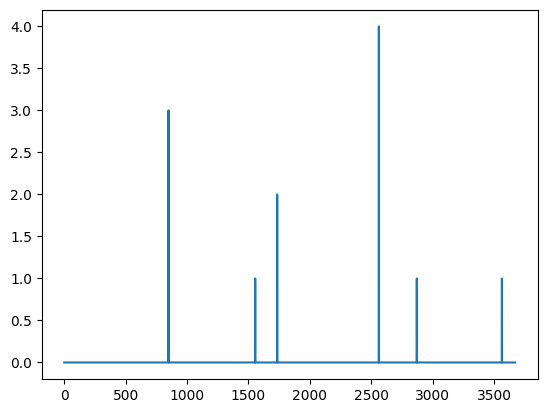

In [102]:
import matplotlib.pyplot as plt
plt.plot(num_wrong)

In [103]:
error_rate = num_wrong.sum() / (num_wrong.shape[0] * 20)

In [104]:
print(f'The error rate is {error_rate}')

The error rate is 0.00016335420637081404
